In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [3]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=7fd71fa9d58999dd55708271daa41762333631f81589b91d65f353d7ed2b1b1a
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval


In [4]:
import json
import re
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
import numpy as np
from seqeval.metrics import f1_score, precision_score, recall_score

In [5]:
# 1. Load and Split the Dataset

orig_dataset = load_dataset("Josephgflowers/Financial-NER-NLP")
# Create an 80/20 train-test split (for evaluation on unseen data)
dataset = orig_dataset["train"].train_test_split(test_size=0.2, seed=42)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.25k [00:00<?, ?B/s]

train.csv:   0%|          | 0.00/367M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/900384 [00:00<?, ? examples/s]

In [ ]:
# 2. Convert Each Example into Token-Level Format

def convert_to_token_level(example):
    text = example["user"]
    tokens = text.split()  # Simple whitespace splitting
    ner_tags = ["O"] * len(tokens)

    assistant_str = example["assistant"]
    try:
        gold_data = json.loads(assistant_str)
    except json.JSONDecodeError:
        try:
            gold_data = json.loads(assistant_str.replace("'", "\""))
        except Exception:
            gold_data = {}

    if not gold_data or (isinstance(gold_data, str) and "No XBRL" in gold_data):
        example["tokens"] = tokens
        example["ner_tags"] = ner_tags
        return example

    for entity_type, values in gold_data.items():
        for val in values:
            pattern = r'\b' + re.escape(val) + r'\b'
            for i, token in enumerate(tokens):
                cleaned_token = re.sub(r'[,\.:;]', '', token)
                if re.fullmatch(pattern, cleaned_token):
                    ner_tags[i] = "B-" + entity_type
    example["tokens"] = tokens
    example["ner_tags"] = ner_tags
    return example

dataset = dataset.map(convert_to_token_level)

In [ ]:
# 3. Build a Label Mapping from the Training Split

unique_labels = set()
for ex in dataset["train"]:
    unique_labels.update(ex["ner_tags"])
unique_labels = sorted(list(unique_labels), key=lambda x: (x != "O", x))
label_list = unique_labels
label_to_id = {label: idx for idx, label in enumerate(label_list)}
num_labels = len(label_list)
print("Label list:", label_list)

# ====================================================
# 4. Convert String Labels to Integer IDs
# ====================================================
def convert_labels_to_ids(example):
    example["ner_tags"] = [label_to_id[tag] for tag in example["ner_tags"]]
    return example

dataset = dataset.map(convert_labels_to_ids)

Label list: ['O', 'B-AccrualForEnvironmentalLossContingencies', 'B-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife', 'B-AllocatedShareBasedCompensationExpense', 'B-AmortizationOfFinancingCosts', 'B-AmortizationOfIntangibleAssets', 'B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'B-AreaOfRealEstateProperty', 'B-AssetImpairmentCharges', 'B-BusinessAcquisitionEquityInterestsIssuedOrIssuableNumberOfSharesIssued', 'B-BusinessAcquisitionPercentageOfVotingInterestsAcquired', 'B-BusinessCombinationAcquisitionRelatedCosts', 'B-BusinessCombinationConsiderationTransferred1', 'B-BusinessCombinationContingentConsiderationLiability', 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumedIntangibleAssetsOtherThanGoodwill', 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumedIntangibles', 'B-CapitalizedContractCostAmortization', 'B-CashAndCashEquivalentsFairValueDisclosure', 'B-ClassOfWarrantOrRightExercisePric

Map:   0%|          | 0/720307 [00:00<?, ? examples/s]

Map:   0%|          | 0/180077 [00:00<?, ? examples/s]

In [ ]:
# 5. Tokenize and Align Labels Using FinBERT's Tokenizer

model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)
    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/720307 [00:00<?, ? examples/s]

Map:   0%|          | 0/180077 [00:00<?, ? examples/s]

In [ ]:
# 6. Downsample the Dataset for Faster Training

small_train_dataset = tokenized_dataset["train"].select(range(50000))
small_test_dataset = tokenized_dataset["test"].select(range(10000))

In [ ]:
# 7. Load the Model with the Updated Number of Labels

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([139, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([139]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 8. Define Evaluation Metrics Using seqeval

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[pred] for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lab] for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

In [ ]:
# 9. Set Up Training Arguments and the Trainer

training_args = TrainingArguments(
    output_dir="./finbert_ner",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,  # increased batch size if possible
    per_device_eval_batch_size=32,
    num_train_epochs=5,              # fewer epochs for a quick experiment
    weight_decay=0.01,
    fp16=True,                       # use mixed precision training
)

data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-155917242ed2>:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [ ]:
# 10. Train the Model

trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sameerkarim99 (sameerkarim99-university-of-california-berkeley) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.012600,0.011327,0.403361,0.045541,0.081841
2,0.009200,0.008937,0.505906,0.243833,0.329065
3,0.007700,0.007840,0.497954,0.346300,0.408506
4,0.006100,0.007303,0.518476,0.425996,0.467708
5,0.005400,0.007244,0.500502,0.473435,0.486592


TrainOutput(global_step=7815, training_loss=0.014335946142864167, metrics={'train_runtime': 6309.1318, 'train_samples_per_second': 39.625, 'train_steps_per_second': 1.239, 'total_flos': 6.54041682653209e+16, 'train_loss': 0.014335946142864167, 'epoch': 5.0})

In [ ]:
eval_metrics = trainer.evaluate()
print(eval_metrics)

{'eval_loss': 0.007243886590003967, 'eval_precision': 0.5005015045135406, 'eval_recall': 0.47343453510436434, 'eval_f1': 0.48659190638712824, 'eval_runtime': 67.9862, 'eval_samples_per_second': 147.089, 'eval_steps_per_second': 4.604, 'epoch': 5.0}


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the output directory on your Google Drive
output_dir = "/content/drive/MyDrive/Colab Notebooks/finbert_ner_model"

# Save the model and tokenizer to Google Drive
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Model saved to {output_dir}")

Mounted at /content/drive
Model saved to /content/drive/MyDrive/Colab Notebooks/finbert_ner_model


#### Summary

We now have established a baseline. The baseline model shows a steady reduction in both training and validation loss over epochs, indicating that it is learning from the data. Initially, the performance was low, with an F1 score around 0.23 in epoch 1. By epoch 4, the model improved considerably—with precision around 0.50, recall around 0.42, and an F1 score of about 0.46—suggesting that the model is beginning to capture relevant entities, though there's still room for improvement. Let's refine and fine tune, starting with data pre-processing.

In [ ]:
!pip install nltk

In [ ]:
import unicodedata
import nltk
from nltk.tokenize import word_tokenize

from transformers import (AutoTokenizer, AutoModelForTokenClassification,
                          TrainingArguments, Trainer, DataCollatorForTokenClassification)
import numpy as np
from seqeval.metrics import f1_score, precision_score, recall_score

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# ====================================================
# 3. Preprocess the Text Data
# ====================================================
def preprocess_text(text):
    # Normalize Unicode to NFKC
    text = unicodedata.normalize("NFKC", text)
    # Replace multiple whitespace with a single space and strip
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    # Use NLTK's word_tokenize for a more robust tokenization
    return word_tokenize(text)

def preprocess_example(example):
    # Preprocess the "user" field text and tokenize it
    preprocessed_text = preprocess_text(example["user"])
    tokens = tokenize_text(preprocessed_text)
    # Update the example with the preprocessed text and tokens
    example["user"] = preprocessed_text
    example["tokens"] = tokens
    return example

# Apply preprocessing to both train and test splits
dataset = dataset.map(preprocess_example)

Map:   0%|          | 0/720307 [00:00<?, ? examples/s]

Map:   0%|          | 0/180077 [00:00<?, ? examples/s]

In [ ]:
# ====================================================
# 4. Convert Each Example to Token-Level Format for NER
# ====================================================
def convert_to_token_level(example):
    tokens = example["tokens"]
    # Initialize all tokens with the "O" label (no entity)
    ner_tags = ["O"] * len(tokens)

    assistant_str = example["assistant"]
    try:
        gold_data = json.loads(assistant_str)
    except json.JSONDecodeError:
        try:
            gold_data = json.loads(assistant_str.replace("'", "\""))
        except Exception:
            gold_data = {}

    # If there's no valid annotation, keep all labels as "O"
    if not gold_data or (isinstance(gold_data, str) and "No XBRL" in gold_data):
        example["ner_tags"] = ner_tags
        return example

    # Mark tokens for each extracted entity
    for entity_type, values in gold_data.items():
        for val in values:
            # Build a regex pattern to match the whole value
            pattern = r'\b' + re.escape(val) + r'\b'
            for i, token in enumerate(tokens):
                # Clean token of punctuation for matching
                cleaned_token = re.sub(r'[,\.:;]', '', token)
                if re.fullmatch(pattern, cleaned_token):
                    ner_tags[i] = "B-" + entity_type
    example["ner_tags"] = ner_tags
    return example

dataset = dataset.map(convert_to_token_level)

Map:   0%|          | 0/720307 [00:00<?, ? examples/s]

Map:   0%|          | 0/180077 [00:00<?, ? examples/s]

In [ ]:
# ====================================================
# 5. Build a Label Mapping from the Training Data
# ====================================================
unique_labels = set()
for ex in dataset["train"]:
    unique_labels.update(ex["ner_tags"])
# Ensure "O" is first, then sort remaining labels
unique_labels = sorted(list(unique_labels), key=lambda x: (x != "O", x))
label_list = unique_labels
label_to_id = {label: idx for idx, label in enumerate(label_list)}
num_labels = len(label_list)
print("Label list:", label_list)

Label list: ['O', 'B-AccrualForEnvironmentalLossContingencies', 'B-AcquiredFiniteLivedIntangibleAssetsWeightedAverageUsefulLife', 'B-AllocatedShareBasedCompensationExpense', 'B-AmortizationOfFinancingCosts', 'B-AmortizationOfIntangibleAssets', 'B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount', 'B-AreaOfRealEstateProperty', 'B-AssetImpairmentCharges', 'B-BusinessAcquisitionEquityInterestsIssuedOrIssuableNumberOfSharesIssued', 'B-BusinessAcquisitionPercentageOfVotingInterestsAcquired', 'B-BusinessCombinationAcquisitionRelatedCosts', 'B-BusinessCombinationConsiderationTransferred1', 'B-BusinessCombinationContingentConsiderationLiability', 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumedIntangibleAssetsOtherThanGoodwill', 'B-BusinessCombinationRecognizedIdentifiableAssetsAcquiredAndLiabilitiesAssumedIntangibles', 'B-CapitalizedContractCostAmortization', 'B-CashAndCashEquivalentsFairValueDisclosure', 'B-ClassOfWarrantOrRightExercisePric

In [ ]:
# ====================================================
# 6. Convert String Labels to Integer IDs
# ====================================================
def convert_labels_to_ids(example):
    example["ner_tags"] = [label_to_id[tag] for tag in example["ner_tags"]]
    return example

dataset = dataset.map(convert_labels_to_ids)

# ====================================================
# 7. Tokenize and Align Labels Using FinBERT's Tokenizer
# ====================================================
model_name = "ProsusAI/finbert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_and_align_labels(examples):
    # Tokenize pre-split tokens; padding and truncation enabled.
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, padding=True, is_split_into_words=True)
    all_labels = []
    for i, labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore special tokens in loss
            elif word_idx != previous_word_idx:
                label_ids.append(labels[word_idx])
            else:
                label_ids.append(labels[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)
    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/720307 [00:00<?, ? examples/s]

Map:   0%|          | 0/180077 [00:00<?, ? examples/s]

Map:   0%|          | 0/720307 [00:00<?, ? examples/s]

Map:   0%|          | 0/180077 [00:00<?, ? examples/s]

In [ ]:
# ====================================================
# 8. Downsample the Dataset for Faster Training (Optional)
# ====================================================
# Adjust the number of examples to reduce training time
small_train_dataset = tokenized_dataset["train"].select(range(50000))
small_test_dataset = tokenized_dataset["test"].select(range(10000))

# ====================================================
# 9. Load the Model (with a Reinitialized Classification Head)
# ====================================================
model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=num_labels,
    ignore_mismatched_sizes=True
)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([139, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([139]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ====================================================
# 10. Define Evaluation Metrics Using seqeval
# ====================================================
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[pred] for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lab] for pred, lab in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return {
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

In [ ]:
# ====================================================
# 11. Set Up Training Arguments and the Trainer
# ====================================================
training_args = TrainingArguments(
    output_dir="./finbert_ner",  # local output; we'll later copy to Drive
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,  # For quick experimentation; adjust as needed
    weight_decay=0.01,
    fp16=True,         # Enable mixed precision for faster training
)

data_collator = DataCollatorForTokenClassification(tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-24-7e84e615efdb>:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ====================================================
# 12. Train the Model
# ====================================================
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.014100,0.012553,0.409091,0.034156,0.063047
2,0.009500,0.009090,0.481132,0.193548,0.276049
3,0.007800,0.008028,0.465714,0.309298,0.371722
4,0.006000,0.007447,0.470884,0.444972,0.457561
5,0.005300,0.007326,0.492417,0.462049,0.476750


TrainOutput(global_step=7815, training_loss=0.015169558110179157, metrics={'train_runtime': 6097.1084, 'train_samples_per_second': 41.003, 'train_steps_per_second': 1.282, 'total_flos': 6.54041682653209e+16, 'train_loss': 0.015169558110179157, 'epoch': 5.0})

In [ ]:
output_dir = "/content/drive/MyDrive/Colab Notebooks/finbert_ner_model"
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/drive/MyDrive/Colab Notebooks/finbert_ner_model


In [ ]:
improved_training_args = TrainingArguments(
    output_dir="./finbert_ner_improved",
    evaluation_strategy="steps",  # Evaluate every fixed number of steps
    eval_steps=500,               # Evaluate every 500 steps
    logging_steps=100,            # Log every 100 steps
    learning_rate=1e-5,           # Lower learning rate for finer updates
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,          # Increase the number of epochs for more training
    weight_decay=0.01,
    fp16=True,                    # Use mixed precision for faster training
    warmup_steps=500,             # Warmup steps to stabilize training early on
)

trainer = Trainer(
    model=model,
    args=improved_training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()



/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-27-8ae577cc45cd>:15: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1
500,0.005200,0.007593,0.453465,0.434535,0.443798
1000,0.004300,0.007990,0.529487,0.391841,0.450382
1500,0.004600,0.007403,0.519914,0.458254,0.487141
2000,0.004500,0.007403,0.493080,0.540797,0.515837
2500,0.003900,0.007435,0.498736,0.561670,0.528336
3000,0.003500,0.007514,0.522936,0.486717,0.504177
3500,0.002300,0.007664,0.485437,0.569260,0.524017
4000,0.002900,0.007227,0.527337,0.567362,0.546618
4500,0.003100,0.008057,0.504673,0.563567,0.532497
5000,0.001800,0.008044,0.508757,0.578748,0.541500


TrainOutput(global_step=15630, training_loss=0.0022492435365743693, metrics={'train_runtime': 13657.624, 'train_samples_per_second': 36.61, 'train_steps_per_second': 1.144, 'total_flos': 1.308092685533209e+17, 'train_loss': 0.0022492435365743693, 'epoch': 10.0})

In [ ]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback

# Improved training arguments
improved_training_args = TrainingArguments(
    output_dir="./finbert_ner_improved",
    evaluation_strategy="steps",     # Evaluate every fixed number of steps
    eval_steps=500,                  # Evaluate every 500 steps
    logging_steps=100,               # Log every 100 steps
    learning_rate=1e-5,              # Lower learning rate for finer updates
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,             # More epochs to allow better convergence
    weight_decay=0.01,
    fp16=True,                       # Mixed precision for faster training (if supported)
    warmup_steps=500,                # Warmup steps to stabilize training early on
    metric_for_best_model="f1"       # Use F1 score to decide the best model
)

# Set up the Trainer with EarlyStoppingCallback
improved_trainer = Trainer(
    model=model,
    args=improved_training_args,
    train_dataset=small_train_dataset,   # Downsampled training set
    eval_dataset=small_test_dataset,       # Downsampled evaluation set
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
    )

# Start training
improved_trainer.train()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-28-70a27c8d7151>:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  improved_trainer = Trainer(


Step,Training Loss,Validation Loss,Precision,Recall,F1
500,0.001100,0.009070,0.522544,0.615750,0.565331
1000,0.001100,0.009466,0.551492,0.543643,0.547539
1500,0.001100,0.008842,0.597838,0.524668,0.558868
2000,0.001100,0.008524,0.533717,0.615750,0.571806
2500,0.001000,0.009380,0.492216,0.629981,0.552643
3000,0.000900,0.008548,0.546713,0.599620,0.571946
3500,0.000400,0.008644,0.546552,0.601518,0.572719
4000,0.000800,0.008771,0.525723,0.620493,0.569191
4500,0.000800,0.008843,0.534646,0.644213,0.584337
5000,0.000500,0.008640,0.574640,0.606262,0.590028


TrainOutput(global_step=15630, training_loss=0.0005043944905518589, metrics={'train_runtime': 13642.0411, 'train_samples_per_second': 36.651, 'train_steps_per_second': 1.146, 'total_flos': 1.308092685533209e+17, 'train_loss': 0.0005043944905518589, 'epoch': 10.0})

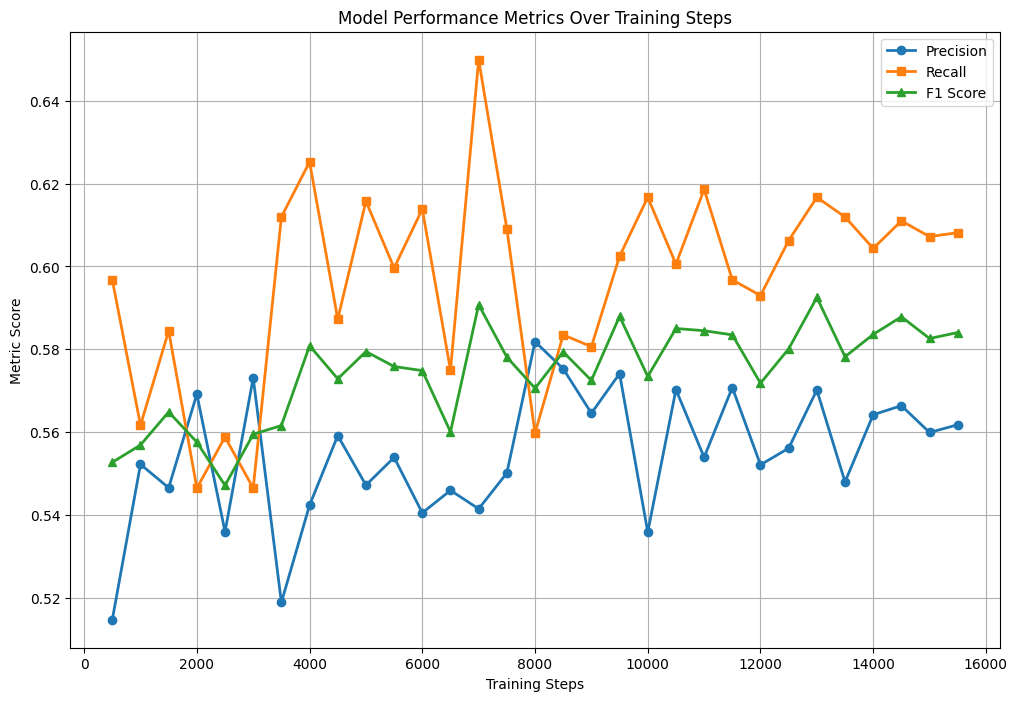

In [2]:
import matplotlib.pyplot as plt


steps = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000,
         5500, 6000, 6500, 7000, 7500, 8000, 8500, 9000, 9500, 10000,
         10500, 11000, 11500, 12000, 12500, 13000, 13500, 14000, 14500, 15000, 15500]

precision = [0.514730, 0.552239, 0.546584, 0.569170, 0.535942, 0.573134, 0.518906, 0.542387, 0.559169, 0.547218,
             0.553900, 0.540518, 0.545946, 0.541502, 0.550129, 0.581854, 0.575304, 0.564576, 0.574141, 0.535862,
             0.570270, 0.553951, 0.570780, 0.552120, 0.556136, 0.570175, 0.548003, 0.564216, 0.566403, 0.559930, 0.561788]

recall = [0.596774, 0.561670, 0.584440, 0.546490, 0.558824, 0.546490, 0.611954, 0.625237, 0.587287, 0.615750,
          0.599620, 0.613852, 0.574953, 0.649905, 0.609108, 0.559772, 0.583491, 0.580645, 0.602467, 0.616698,
          0.600569, 0.618596, 0.596774, 0.592979, 0.606262, 0.616698, 0.611954, 0.604364, 0.611006, 0.607211, 0.608159]

f1 = [0.552724, 0.556914, 0.564878, 0.557599, 0.547144, 0.559495, 0.561602, 0.580873, 0.572883, 0.579464,
      0.575854, 0.574856, 0.560074, 0.590772, 0.578118, 0.570600, 0.579369, 0.572498, 0.587963, 0.573445,
      0.585028, 0.584491, 0.583488, 0.571821, 0.580118, 0.592525, 0.578216, 0.583601, 0.587859, 0.582613, 0.584055]

# Plot the metrics over training steps
plt.figure(figsize=(12, 8))
plt.plot(steps, precision, label='Precision', marker='o', linewidth=2)
plt.plot(steps, recall, label='Recall', marker='s', linewidth=2)
plt.plot(steps, f1, label='F1 Score', marker='^', linewidth=2)
plt.xlabel('Training Steps')
plt.ylabel('Metric Score')
plt.title('Model Performance Metrics Over Training Steps')
plt.legend()
plt.grid(True)
plt.show()


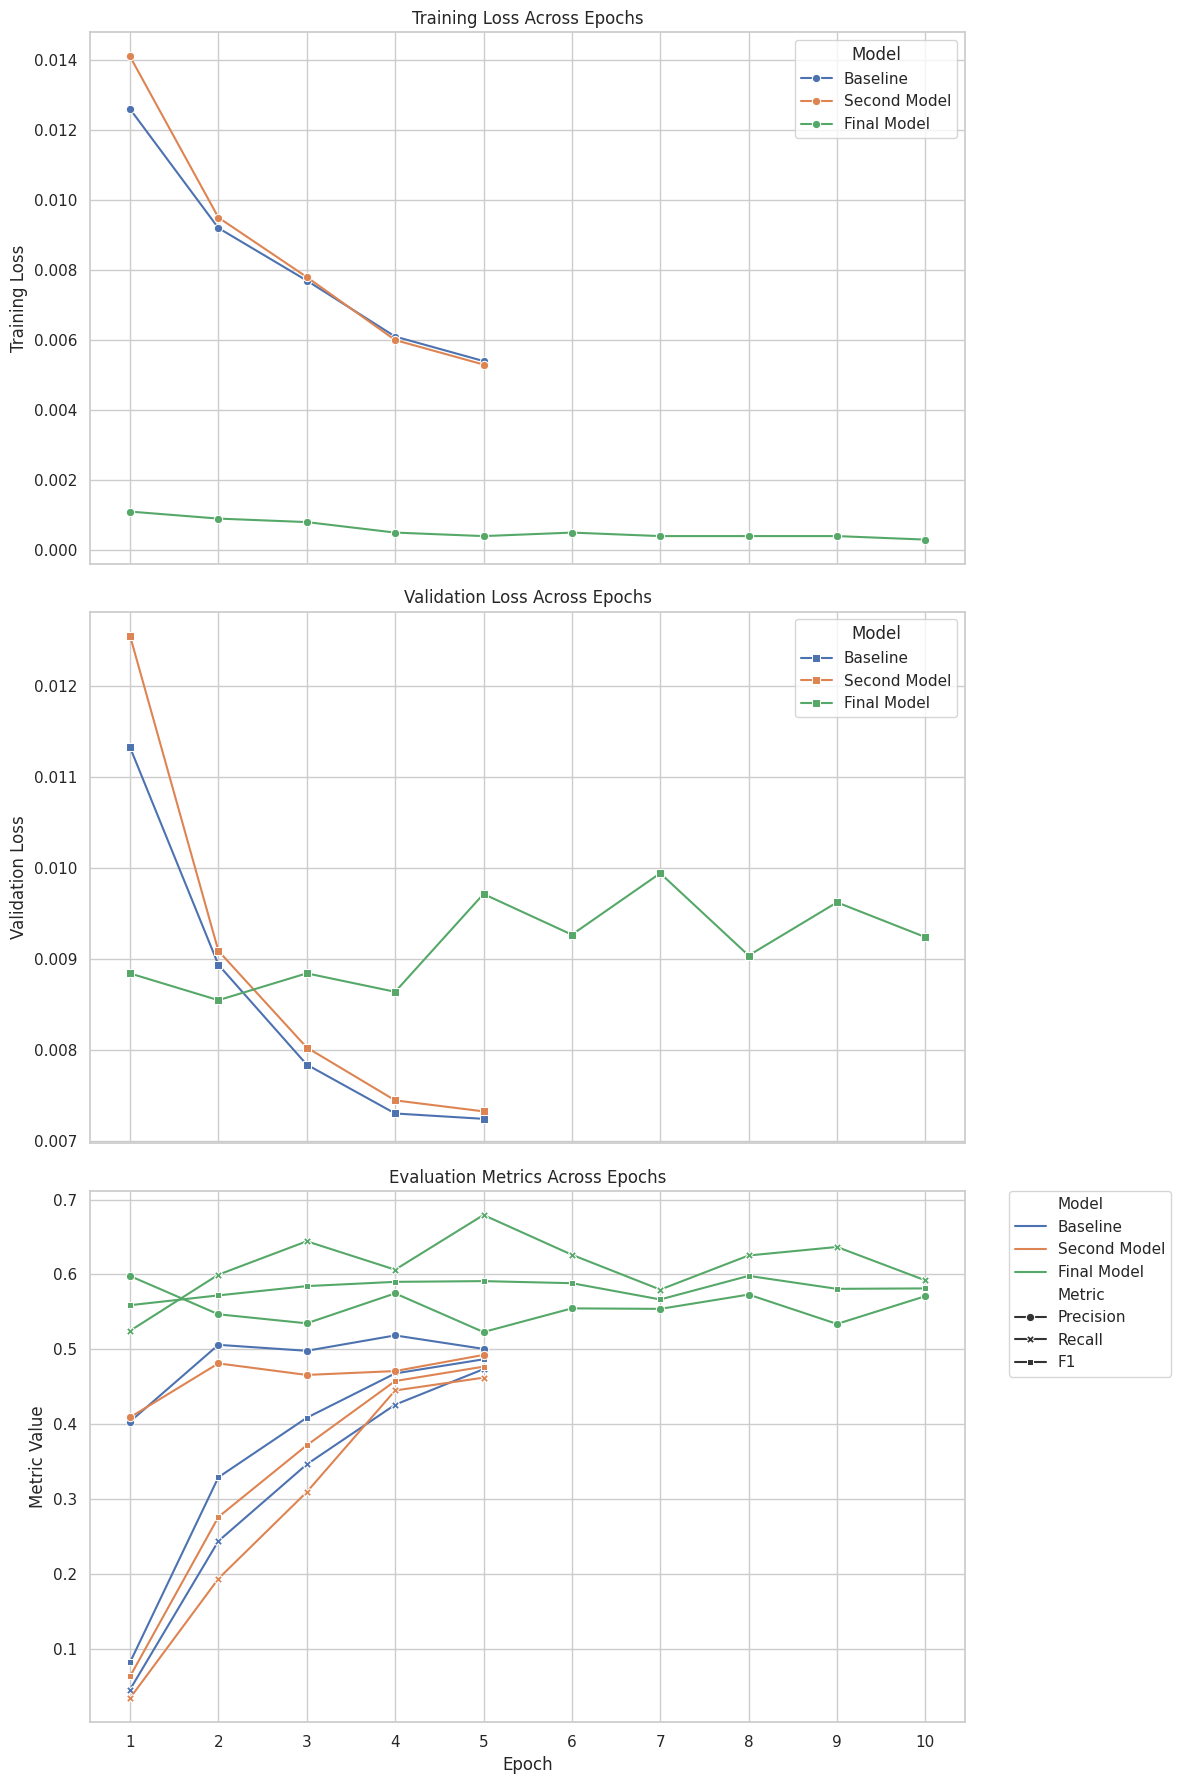

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Define epoch numbers for the models
# ------------------------------
# Baseline and Second models have 5 epochs.
baseline_epochs = [1, 2, 3, 4, 5]
final_epochs = list(range(1, 11))  # Final model: 10 epochs

# ------------------------------
# Baseline Model Metrics (5 epochs)
# ------------------------------
baseline_data = {
    "Epoch": baseline_epochs,
    "Train Loss": [0.012600, 0.009200, 0.007700, 0.006100, 0.005400],
    "Validation Loss": [0.011327, 0.008937, 0.007840, 0.007303, 0.007244],
    "Precision": [0.403361, 0.505906, 0.497954, 0.518476, 0.500502],
    "Recall": [0.045541, 0.243833, 0.346300, 0.425996, 0.473435],
    "F1": [0.081841, 0.329065, 0.408506, 0.467708, 0.486592]
}
baseline_df = pd.DataFrame(baseline_data)
baseline_df["Model"] = "Baseline"

# ------------------------------
# Second Model Metrics (5 epochs)
# ------------------------------
second_data = {
    "Epoch": baseline_epochs,
    "Train Loss": [0.014100, 0.009500, 0.007800, 0.006000, 0.005300],
    "Validation Loss": [0.012553, 0.009090, 0.008028, 0.007447, 0.007326],
    "Precision": [0.409091, 0.481132, 0.465714, 0.470884, 0.492417],
    "Recall": [0.034156, 0.193548, 0.309298, 0.444972, 0.462049],
    "F1": [0.063047, 0.276049, 0.371722, 0.457561, 0.476750]
}
second_df = pd.DataFrame(second_data)
second_df["Model"] = "Second Model"

# ------------------------------
# Final Model Metrics (10 epochs, using representative steps)
# ------------------------------
final_data = {
    "Epoch": final_epochs,
    "Train Loss": [0.001100, 0.000900, 0.000800, 0.000500, 0.000400, 0.000500, 0.000400, 0.000400, 0.000400, 0.000300],
    "Validation Loss": [0.008842, 0.008548, 0.008843, 0.008640, 0.009715, 0.009268, 0.009943, 0.009039, 0.009623, 0.009241],
    "Precision": [0.597838, 0.546713, 0.534646, 0.574640, 0.523009, 0.554622, 0.553944, 0.573043, 0.533811, 0.570906],
    "Recall": [0.524668, 0.599620, 0.644213, 0.606262, 0.679317, 0.626186, 0.579696, 0.625237, 0.636622, 0.592030],
    "F1": [0.558868, 0.571946, 0.584337, 0.590028, 0.591003, 0.588235, 0.566528, 0.598004, 0.580701, 0.581276]
}
final_df = pd.DataFrame(final_data)
final_df["Model"] = "Final Model"

# ------------------------------
# Combine all DataFrames
# ------------------------------
all_df = pd.concat([baseline_df, second_df, final_df], ignore_index=True)

# ------------------------------
# Plotting
# ------------------------------
sns.set(style="whitegrid")
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Plot Training Loss
sns.lineplot(data=all_df, x="Epoch", y="Train Loss", hue="Model", marker="o", ax=axs[0])
axs[0].set_title("Training Loss Across Epochs")
axs[0].set_ylabel("Training Loss")
axs[0].set_xticks(sorted(all_df["Epoch"].unique()))

# Plot Validation Loss
sns.lineplot(data=all_df, x="Epoch", y="Validation Loss", hue="Model", marker="s", ax=axs[1])
axs[1].set_title("Validation Loss Across Epochs")
axs[1].set_ylabel("Validation Loss")
axs[1].set_xticks(sorted(all_df["Epoch"].unique()))

# Plot Evaluation Metrics: Precision, Recall, F1
# Melt the DataFrame to long format for metrics
metrics_df = all_df.melt(id_vars=["Epoch", "Model"], value_vars=["Precision", "Recall", "F1"],
                         var_name="Metric", value_name="Value")
sns.lineplot(data=metrics_df, x="Epoch", y="Value", hue="Model", style="Metric", markers=True, dashes=False, ax=axs[2])
axs[2].set_title("Evaluation Metrics Across Epochs")
axs[2].set_ylabel("Metric Value")
axs[2].set_xticks(sorted(all_df["Epoch"].unique()))
axs[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel("Epoch")
plt.tight_layout()
plt.show()


<ipython-input-8-3723e5a7e2eb>:31: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


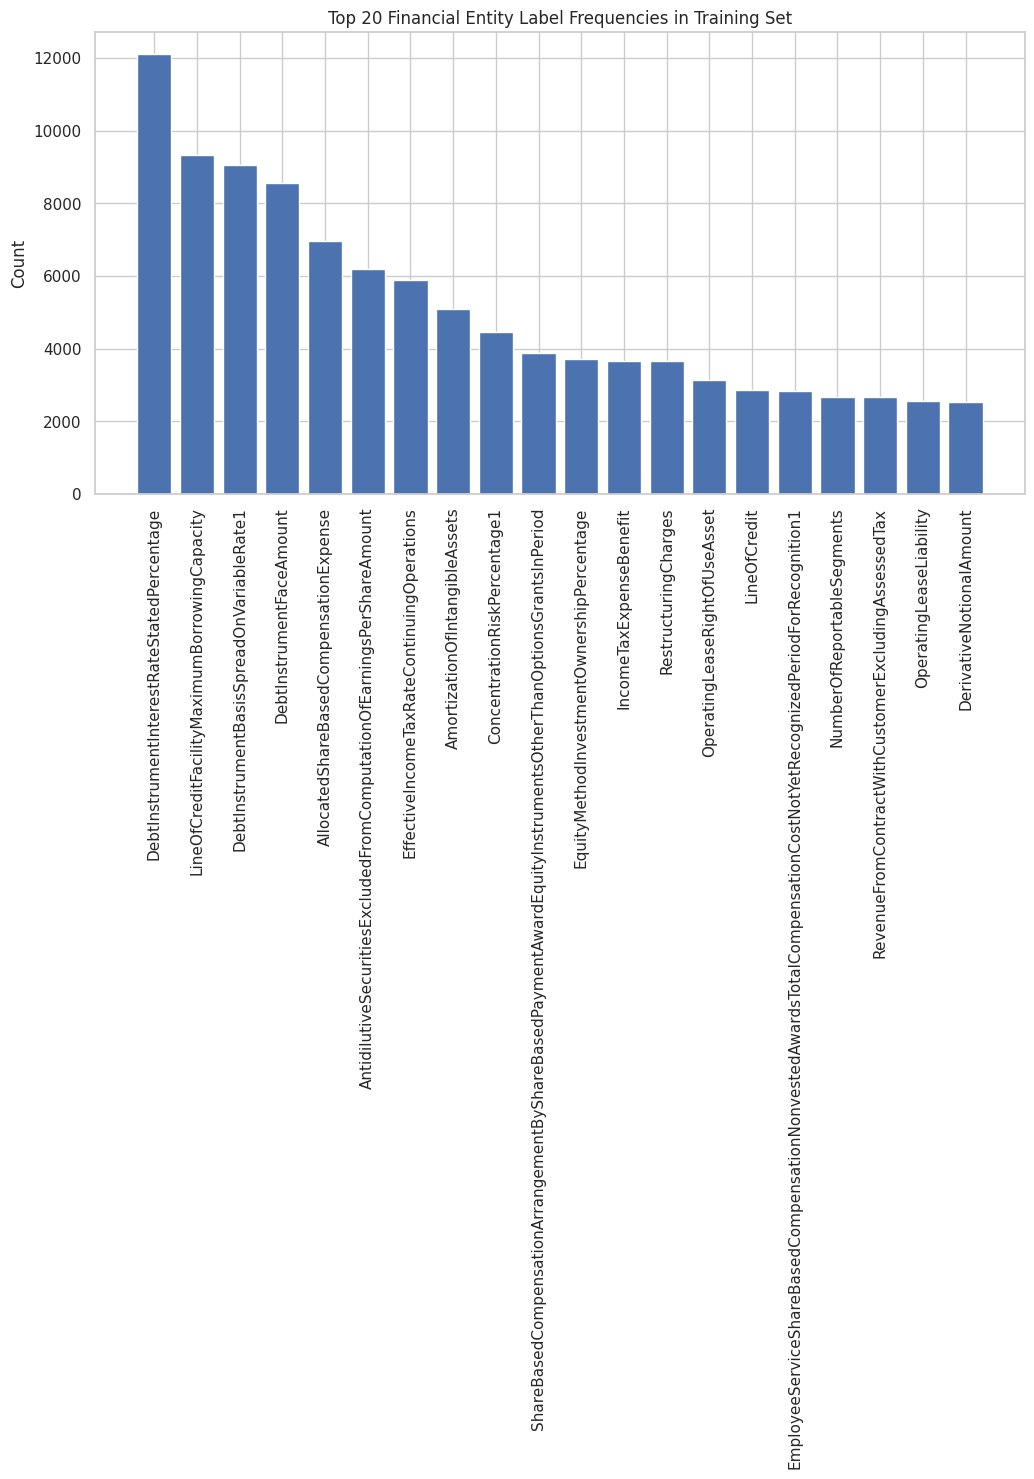

In [8]:
import matplotlib.pyplot as plt
from collections import Counter

# Function to extract label counts from the assistant field
def extract_label_counts(example):
    counts = {}
    try:
        label_data = json.loads(example["assistant"].replace("'", '"'))
        if isinstance(label_data, dict):
            for key, value in label_data.items():
                counts[key] = len(value)
    except:
        pass
    return counts

# Count labels in training data
label_counter = Counter()
for ex in dataset["train"]:
    ex_counts = extract_label_counts(ex)
    label_counter.update(ex_counts)

# Convert to sorted list for plotting
labels, counts = zip(*label_counter.most_common(20))  # Top 20 only for readability

# Plot
plt.figure(figsize=(12, 6))
plt.bar(labels, counts)
plt.xticks(rotation=90)
plt.title("Top 20 Financial Entity Label Frequencies in Training Set")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
